# Transcription Factor Classifier

In [60]:
from nn import NeuralNetwork
import numpy as np
from typing import List, Dict, Tuple, Union
from numpy.typing import ArrayLike
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import pandas as pd
from TFC_io import read_text_file, read_fasta_file
from preprocess import sample_seqs, one_hot_encode_seqs, correct_length
import matplotlib.pyplot as plt

### Read in Rap1 motif examples

In [2]:
pos_seqs = read_text_file("../data/rap1-lieb-positives.txt")
pos_labels = [True for i in range(len(pos_seqs))] #generate labels, where True = positive

### Read in negative example from yeast

In [3]:
neg_seqs = read_fasta_file("../data/yeast-upstream-1k-negative.fa")

### Correct lengths of longer negative sequences by splitting them up into multiple sequences

In [4]:
yeast_neg_corrected = correct_length(pos_seqs, neg_seqs)
print("Number of negative sequences: ", len(yeast_neg_corrected))
print("Number of positive sequences: ", len(pos_seqs))
neg_labels = [False for i in range(len(yeast_neg_corrected))]

Number of negative sequences:  183297
Number of positive sequences:  137


### Explain Sampling Scheme
I chose to use oversampling to correct the class imbalance in the data by resampling the positive class with replacement until it had the same number of observations as the negative class. While this can make the classification model prone to ovefitting, it prevents information loss and avoids an extremely small sample size if we were to downsample the negative sequences to the size of the pos_seqs.

### Implement sampling scheme

In [5]:
seqs = pos_seqs + yeast_neg_corrected #combine the two lists of seqs
labels = pos_labels + neg_labels #combine the two lists of labels
new_seqs, new_labels = sample_seqs(seqs, labels) #fix class imbalance
print(len(new_seqs)) #should be 36594
print(len(new_labels)) #should be 36594

366594
366594


### Generate training, validation, and held out sets

In [6]:
#use a 70/30 train/test split, and hold out 10% of the data for later accuracy assessment
train_val_x, held_out_x, train_val_y, held_out_y = train_test_split(new_seqs, new_labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(train_val_x, train_val_y, test_size=0.3, random_state = 42)

print(len(held_out_x))
print(len(X_train))
print(len(X_val))

36660
230953
98981


### One hot encode the sequences in the training, test, and validation sets

In [7]:
held_out_encoded = one_hot_encode_seqs(held_out_x)
X_train_encoded = one_hot_encode_seqs(X_train)
X_val_encoded = one_hot_encode_seqs(X_val)

In [8]:
#make sure to expand the dimensions of the expected outputs and format as numpy arrays
y_train = np.array(np.expand_dims(np.array(y_train),axis=1))
y_val = np.array(np.expand_dims(np.array(y_val),axis=1))
held_out_y = np.array(np.expand_dims(np.array(held_out_y),axis=1))

### However,...
since these sizes are all quite large to work with, in the interest of avoiding large runtimes, I will take only the top 200 for the hold out set, the top 1500 for the validation set, and the top 5000 for the training set

In [9]:
small_X_train = X_train_encoded[0:5000]
small_X_val = X_val_encoded[0:1500]
small_held_outX = held_out_encoded[0:200]

small_y_train = y_train[0:5000]
small_y_val = y_val[0:1500]
small_held_outY = held_out_y[0:200]

### Define plotting function so loss history of neural network can be visualized

In [10]:
def plot_loss_history(per_epoch_loss_train, per_epoch_loss_val):
    """
    Plots the loss history after training is complete.
    """
    loss_hist = per_epoch_loss_train
    loss_hist_val = per_epoch_loss_val
    assert len(loss_hist) > 0, "Need to run training before plotting loss history"
    fig, axs = plt.subplots(2, figsize=(8,8))
    fig.suptitle('Loss History')
    axs[0].plot(np.arange(len(loss_hist)), loss_hist)
    axs[0].set_title('Training Loss')
    axs[1].plot(np.arange(len(loss_hist_val)), loss_hist_val)
    axs[1].set_title('Validation Loss')
    plt.xlabel('Steps')
    axs[0].set_ylabel('Train Loss')
    axs[1].set_ylabel('Val Loss')
    fig.tight_layout()

### Train a neural network

In [27]:
nn_arch = [{'input_dim': 68, 'output_dim': 5, 'activation': 'sigmoid'},
           {'input_dim': 5, 'output_dim': 1, 'activation': 'sigmoid'}]
classifier = NeuralNetwork(nn_arch, 
                          lr=0.01, 
                          seed=42, 
                          batch_size=20, 
                          epochs=10,
                          loss_function = "binary cross entropy")

2.3391206565352523

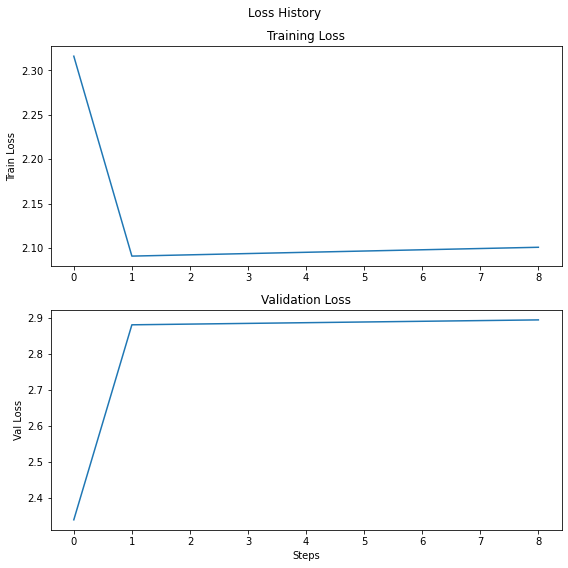

In [28]:
per_epoch_loss_train, per_epoch_loss_val = classifier.fit(small_X_train, small_y_train, small_X_val, small_y_val)
plot_loss_history(per_epoch_loss_train, per_epoch_loss_val)
min(per_epoch_loss_val)

### Try another neural net structure

In [29]:
nn_arch = [{'input_dim': 68, 'output_dim': 16, 'activation': 'sigmoid'},
           {'input_dim': 16, 'output_dim': 5, 'activation': 'sigmoid'},
          {'input_dim': 5, 'output_dim': 1, 'activation': 'sigmoid'}]
classifier2 = NeuralNetwork(nn_arch, 
                          lr=0.00001, 
                          seed=42, 
                          batch_size=20, 
                          epochs=10,
                          loss_function = "binary cross entropy")

0.698805362721396

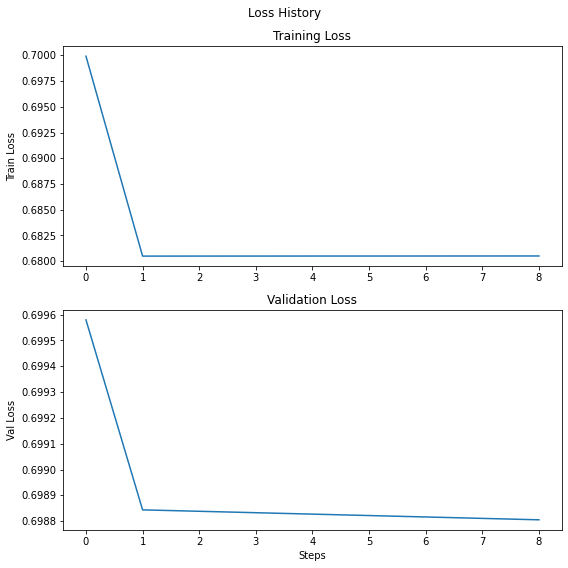

In [30]:
per_epoch_loss_train, per_epoch_loss_val = classifier2.fit(small_X_train, small_y_train, small_X_val, small_y_val)
plot_loss_history(per_epoch_loss_train, per_epoch_loss_val)
min(per_epoch_loss_val)

It looks like adding another layer and decreasing the learning rate imroved performance. Will adding one more layer improve it further?

In [48]:
nn_arch = [{'input_dim': 68, 'output_dim': 40, 'activation': 'sigmoid'},
           {'input_dim': 40, 'output_dim': 16, 'activation': 'sigmoid'},
           {'input_dim': 16, 'output_dim': 5, 'activation': 'sigmoid'},
          {'input_dim': 5, 'output_dim': 1, 'activation': 'sigmoid'}]
classifier3 = NeuralNetwork(nn_arch, 
                          lr=0.00001, 
                          seed=42, 
                          batch_size=20, 
                          epochs=200,
                          loss_function = "binary cross entropy")

0.693007113826978

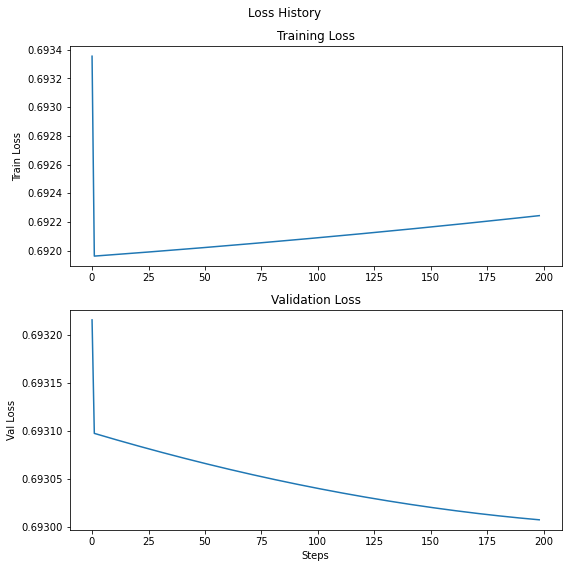

In [49]:
per_epoch_loss_train, per_epoch_loss_val = classifier3.fit(small_X_train, small_y_train, small_X_val, small_y_val)
plot_loss_history(per_epoch_loss_train, per_epoch_loss_val)
min(per_epoch_loss_val)

Adding extra layers isn't improving performance drastically. How about changing the batch size?

In [42]:
nn_arch = [{'input_dim': 68, 'output_dim': 16, 'activation': 'sigmoid'},
           {'input_dim': 16, 'output_dim': 5, 'activation': 'sigmoid'},
          {'input_dim': 5, 'output_dim': 1, 'activation': 'sigmoid'}]
classifier4 = NeuralNetwork(nn_arch, 
                          lr=0.00001, 
                          seed=42, 
                          batch_size=200, 
                          epochs=250,
                          loss_function = "binary cross entropy")

0.6927115146557876

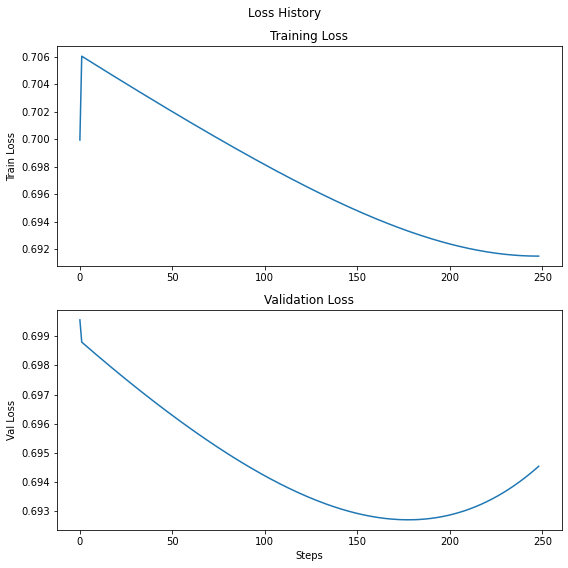

In [43]:
per_epoch_loss_train, per_epoch_loss_val = classifier4.fit(small_X_train, small_y_train, small_X_val, small_y_val)
plot_loss_history(per_epoch_loss_train, per_epoch_loss_val)
min(per_epoch_loss_val)

### Hyperparameter choices:
Number of hidden layers = 2,
Learning rate = 0.00001,
Batch size = 200,
Epochs = 250,
Loss function = Binary Cross Entropy


I chose to use binary cross entropy as my loss function because we are trying to predict a binary output, either 0 (the motif is not a binding site for Rap1) or 1 (the motif is a binding site for Rap1). I chose the other hyperaparameters I did because, as shown in the above plots, they give the lowest validation loss and a relatively low training error. They also cause the loss functions to behave in a more 'normal' way compared to other hyperparameters.

### See the plots above "Hyperparameter choices" for the loss per epoch of the final model

### Accuracy of classifier

In [55]:
#Using the small held out set from the beginning, get classified predictions
preds = classifier4.predict(small_held_outX)
preds_classified = np.ones((len(preds),1))
for i in range(len(preds)):
    if preds[i]>=0.5:
        preds_classified[i] = 1
    else:
        preds_classified[i] = 0

In [58]:
accuracy = np.sum(small_held_outY==preds_classified)/len(preds)
print("Accuracy: ", accuracy)

Accuracy:  0.545
